In [1]:
import gym
import numpy as np
import tensorflow as tf
import pickle
import os
from os import path

In [2]:
TOTAL_STEPS = 5000
TRAINING_STEPS = 3000
VALIDATION_STEPS = 1000
BATCH_SIZE = 64

## Cartpole-v0 Info
### Action Space
    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.
    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |
    
### Observation Space
    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:
    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8                 | 4.8                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°)  | ~ 0.418 rad (24°)  |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |
    
(https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

In [3]:
env = gym.make('CartPole-v0')
X = np.empty((TOTAL_STEPS, 4)) # len(env.observation_space.sample()) == 4
U = np.empty((TOTAL_STEPS, 1))
y = np.empty((TOTAL_STEPS, 4))

In [4]:
tf.random.set_seed(1)
np.random.seed(1)

In [73]:
#### TEST ####
x_present = env.reset()
for timestep in range(1):
    u = env.action_space.sample() # sidenote: should this be one-hot encoded?
    x_prime, _, done, _ = env.step(u)
    
    # sample x[n], u[n], and x[n+1]
    X[timestep] = x_present
    U[timestep] = u
    y[timestep] = x_prime
    x_present = x_prime
print(X[0])
print(U[0])
print(y[0])

[-0.04416447  0.03527697 -0.00501254  0.04463949]
[1.]
[-0.04345893  0.23047043 -0.00411975 -0.24962072]


In [74]:
#### "Let-it-run method" ####
for iteration in range(TOTAL_STEPS // 1000):
    x_present = env.reset()
    for timestep in range(1000):
        u = env.action_space.sample() # sidenote: should this be one-hot encoded?
        x_prime, _, done, _ = env.step(u)

        # sample x[n], u[n], and x[n+1]
        X[1000 * iteration + timestep] = x_present
        U[1000 * iteration + timestep] = u
        y[1000 * iteration + timestep] = x_prime
        x_present = x_prime
env.close()

/Users/johnlime/anaconda3/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


In [5]:
x_present = env.reset()
for num_timestep in range(TOTAL_STEPS):
    u = env.action_space.sample() # sidenote: should this be one-hot encoded?
    x_prime, _, done, _ = env.step(u)

    # sample x[n], u[n], and x[n+1]
    X[num_timestep] = x_present
    U[num_timestep] = u
    y[num_timestep] = x_prime
    x_present = x_prime
    if done:
        x_present = env.reset()
env.close()

In [6]:
class CartpoleLinearControlSystem(tf.keras.Model):
    def __init__(self):
        super(CartpoleLinearControlSystem, self).__init__()
        self.A = tf.keras.layers.Dense(4, input_shape = (4, ), activation = 'linear', name = 'A')
        self.B = tf.keras.layers.Dense(4, input_shape = (1, ), activation = 'linear', name = 'B')
        self.add = tf.keras.layers.Add()
        
    def call(self, inputs):
        x, u = inputs
        return self.A(x) + self.B(u)

Uses reference code in *Python Machine Learning: 3rd Edition* (Raschka and Mirjalili, 2019) pp. 438, 512-515

In [7]:
if not path.exists('./cartpole_system_model'):
  os.mkdir('./cartpole_system_model')

In [8]:
# create tensorflow dataset object instance; concat X and y
dataset_xu = tf.data.Dataset.from_tensors((X, U))
dataset_y = tf.data.Dataset.from_tensors(y)
dataset = tf.data.Dataset.zip((dataset_xu, dataset_y)).shuffle(1000)
print(dataset)
# split trajectories into training, validation, and testing
dataset_training = dataset.take(TRAINING_STEPS)
dataset_validation = dataset.skip(TRAINING_STEPS).take(VALIDATION_STEPS)
dataset_testing = dataset.skip(TRAINING_STEPS + VALIDATION_STEPS)
# split training data into batches
dataset_training = dataset_training.repeat(5).batch(BATCH_SIZE)

<ShuffleDataset shapes: (((5000, 4), (5000, 1)), (5000, 4)), types: ((tf.float64, tf.float64), tf.float64)>


2022-03-06 15:02:55.067265: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
tf.data.experimental.save(dataset_training, './cartpole_system_model/dataset_training')
tf.data.experimental.save(dataset_validation, './cartpole_system_model/dataset_validation')
tf.data.experimental.save(dataset_testing, './cartpole_system_model/dataset_testing')

2022-03-06 15:02:58.626029: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


In [10]:
# compile model
model = CartpoleLinearControlSystem()
model.compile(tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = [tf.keras.metrics.MeanSquaredError()])
history = model.fit(dataset_training, validation_data = dataset_validation, epochs = 3000)
tf.keras.models.save_model(
    model, './cartpole_system_model', overwrite = True, include_optimizer = True, save_format = None,
    signatures = None, options = None, save_traces = True
)

Epoch 1/3000
1/1 [==============================] - 1s 525ms/step - loss: 0.7880 - mean_squared_error: 0.7880
Epoch 2/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.7853 - mean_squared_error: 0.7853
Epoch 3/3000
1/1 [==============================] - 0s 21ms/step - loss: 0.7827 - mean_squared_error: 0.7827
Epoch 4/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.7800 - mean_squared_error: 0.7800
Epoch 5/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.7774 - mean_squared_error: 0.7774
Epoch 6/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.7748 - mean_squared_error: 0.7748
Epoch 7/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.7722 - mean_squared_error: 0.7722
Epoch 8/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.7696 - mean_squared_error: 0.7696
Epoch 9/3000
1/1 [==============================] - 0s 21ms/step - loss: 0.7671 - mean_squared_error: 0.7671
Epoch 10/3000
1/1 

1/1 [==============================] - 0s 18ms/step - loss: 0.6258 - mean_squared_error: 0.6258
Epoch 76/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.6240 - mean_squared_error: 0.6240
Epoch 77/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.6222 - mean_squared_error: 0.6222
Epoch 78/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.6204 - mean_squared_error: 0.6204
Epoch 79/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.6186 - mean_squared_error: 0.6186
Epoch 80/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.6168 - mean_squared_error: 0.6168
Epoch 81/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.6151 - mean_squared_error: 0.6151
Epoch 82/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.6133 - mean_squared_error: 0.6133
Epoch 83/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.6116 - mean_squared_error: 0.6116
Epoch 84/3000
1/1 [=====

1/1 [==============================] - 0s 20ms/step - loss: 0.5103 - mean_squared_error: 0.5103
Epoch 150/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.5090 - mean_squared_error: 0.5090
Epoch 151/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.5076 - mean_squared_error: 0.5076
Epoch 152/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.5063 - mean_squared_error: 0.5063
Epoch 153/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.5050 - mean_squared_error: 0.5050
Epoch 154/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.5036 - mean_squared_error: 0.5036
Epoch 155/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.5023 - mean_squared_error: 0.5023
Epoch 156/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.5010 - mean_squared_error: 0.5010
Epoch 157/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.4997 - mean_squared_error: 0.4997
Epoch 158/3000
1

1/1 [==============================] - 0s 16ms/step - loss: 0.4225 - mean_squared_error: 0.4225
Epoch 223/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.4214 - mean_squared_error: 0.4214
Epoch 224/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.4203 - mean_squared_error: 0.4203
Epoch 225/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.4193 - mean_squared_error: 0.4193
Epoch 226/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.4182 - mean_squared_error: 0.4182
Epoch 227/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.4171 - mean_squared_error: 0.4171
Epoch 228/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.4161 - mean_squared_error: 0.4161
Epoch 229/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.4150 - mean_squared_error: 0.4150
Epoch 230/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.4140 - mean_squared_error: 0.4140
Epoch 231/3000
1

1/1 [==============================] - 0s 15ms/step - loss: 0.3510 - mean_squared_error: 0.3510
Epoch 296/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.3501 - mean_squared_error: 0.3501
Epoch 297/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.3492 - mean_squared_error: 0.3492
Epoch 298/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.3484 - mean_squared_error: 0.3484
Epoch 299/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.3475 - mean_squared_error: 0.3475
Epoch 300/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.3466 - mean_squared_error: 0.3466
Epoch 301/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.3457 - mean_squared_error: 0.3457
Epoch 302/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.3448 - mean_squared_error: 0.3448
Epoch 303/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.3440 - mean_squared_error: 0.3440
Epoch 304/3000
1

1/1 [==============================] - 0s 18ms/step - loss: 0.2914 - mean_squared_error: 0.2914
Epoch 369/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.2906 - mean_squared_error: 0.2906
Epoch 370/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.2899 - mean_squared_error: 0.2899
Epoch 371/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.2892 - mean_squared_error: 0.2892
Epoch 372/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.2884 - mean_squared_error: 0.2884
Epoch 373/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.2877 - mean_squared_error: 0.2877
Epoch 374/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.2869 - mean_squared_error: 0.2869
Epoch 375/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.2862 - mean_squared_error: 0.2862
Epoch 376/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.2855 - mean_squared_error: 0.2855
Epoch 377/3000
1

1/1 [==============================] - 0s 16ms/step - loss: 0.2413 - mean_squared_error: 0.2413
Epoch 442/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.2407 - mean_squared_error: 0.2407
Epoch 443/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.2401 - mean_squared_error: 0.2401
Epoch 444/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.2394 - mean_squared_error: 0.2394
Epoch 445/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.2388 - mean_squared_error: 0.2388
Epoch 446/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.2382 - mean_squared_error: 0.2382
Epoch 447/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.2376 - mean_squared_error: 0.2376
Epoch 448/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.2370 - mean_squared_error: 0.2370
Epoch 449/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.2363 - mean_squared_error: 0.2363
Epoch 450/3000
1

1/1 [==============================] - 0s 16ms/step - loss: 0.1993 - mean_squared_error: 0.1993
Epoch 515/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1987 - mean_squared_error: 0.1987
Epoch 516/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1982 - mean_squared_error: 0.1982
Epoch 517/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.1977 - mean_squared_error: 0.1977
Epoch 518/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.1972 - mean_squared_error: 0.1972
Epoch 519/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.1967 - mean_squared_error: 0.1967
Epoch 520/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1961 - mean_squared_error: 0.1961
Epoch 521/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1956 - mean_squared_error: 0.1956
Epoch 522/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1951 - mean_squared_error: 0.1951
Epoch 523/3000
1

1/1 [==============================] - 0s 16ms/step - loss: 0.1641 - mean_squared_error: 0.1641
Epoch 588/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1636 - mean_squared_error: 0.1636
Epoch 589/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.1632 - mean_squared_error: 0.1632
Epoch 590/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1627 - mean_squared_error: 0.1627
Epoch 591/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1623 - mean_squared_error: 0.1623
Epoch 592/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1619 - mean_squared_error: 0.1619
Epoch 593/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.1614 - mean_squared_error: 0.1614
Epoch 594/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1610 - mean_squared_error: 0.1610
Epoch 595/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1606 - mean_squared_error: 0.1606
Epoch 596/3000
1

1/1 [==============================] - 0s 15ms/step - loss: 0.1347 - mean_squared_error: 0.1347
Epoch 661/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1343 - mean_squared_error: 0.1343
Epoch 662/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.1339 - mean_squared_error: 0.1339
Epoch 663/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1336 - mean_squared_error: 0.1336
Epoch 664/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1332 - mean_squared_error: 0.1332
Epoch 665/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1329 - mean_squared_error: 0.1329
Epoch 666/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1325 - mean_squared_error: 0.1325
Epoch 667/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1321 - mean_squared_error: 0.1321
Epoch 668/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.1318 - mean_squared_error: 0.1318
Epoch 669/3000
1

1/1 [==============================] - 0s 17ms/step - loss: 0.1102 - mean_squared_error: 0.1102
Epoch 734/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.1099 - mean_squared_error: 0.1099
Epoch 735/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.1096 - mean_squared_error: 0.1096
Epoch 736/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.1093 - mean_squared_error: 0.1093
Epoch 737/3000
1/1 [==============================] - 0s 21ms/step - loss: 0.1090 - mean_squared_error: 0.1090
Epoch 738/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.1087 - mean_squared_error: 0.1087
Epoch 739/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.1084 - mean_squared_error: 0.1084
Epoch 740/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.1081 - mean_squared_error: 0.1081
Epoch 741/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.1078 - mean_squared_error: 0.1078
Epoch 742/3000
1

1/1 [==============================] - 0s 21ms/step - loss: 0.0900 - mean_squared_error: 0.0900
Epoch 807/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0897 - mean_squared_error: 0.0897
Epoch 808/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0895 - mean_squared_error: 0.0895
Epoch 809/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0892 - mean_squared_error: 0.0892
Epoch 810/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0890 - mean_squared_error: 0.0890
Epoch 811/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0887 - mean_squared_error: 0.0887
Epoch 812/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0885 - mean_squared_error: 0.0885
Epoch 813/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0882 - mean_squared_error: 0.0882
Epoch 814/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0880 - mean_squared_error: 0.0880
Epoch 815/3000
1

1/1 [==============================] - 0s 18ms/step - loss: 0.0732 - mean_squared_error: 0.0732
Epoch 880/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0730 - mean_squared_error: 0.0730
Epoch 881/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0728 - mean_squared_error: 0.0728
Epoch 882/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0726 - mean_squared_error: 0.0726
Epoch 883/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0724 - mean_squared_error: 0.0724
Epoch 884/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0722 - mean_squared_error: 0.0722
Epoch 885/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0720 - mean_squared_error: 0.0720
Epoch 886/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0718 - mean_squared_error: 0.0718
Epoch 887/3000
1/1 [==============================] - 0s 21ms/step - loss: 0.0716 - mean_squared_error: 0.0716
Epoch 888/3000
1

1/1 [==============================] - 0s 15ms/step - loss: 0.0595 - mean_squared_error: 0.0595
Epoch 953/3000
1/1 [==============================] - 0s 14ms/step - loss: 0.0593 - mean_squared_error: 0.0593
Epoch 954/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0592 - mean_squared_error: 0.0592
Epoch 955/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 956/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0588 - mean_squared_error: 0.0588
Epoch 957/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0587 - mean_squared_error: 0.0587
Epoch 958/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0585 - mean_squared_error: 0.0585
Epoch 959/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0583 - mean_squared_error: 0.0583
Epoch 960/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0582 - mean_squared_error: 0.0582
Epoch 961/3000
1

1/1 [==============================] - 0s 14ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 1026/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0481 - mean_squared_error: 0.0481
Epoch 1027/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0480 - mean_squared_error: 0.0480
Epoch 1028/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0479 - mean_squared_error: 0.0479
Epoch 1029/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0477 - mean_squared_error: 0.0477
Epoch 1030/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0476 - mean_squared_error: 0.0476
Epoch 1031/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0475 - mean_squared_error: 0.0475
Epoch 1032/3000
1/1 [==============================] - 0s 21ms/step - loss: 0.0473 - mean_squared_error: 0.0473
Epoch 1033/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0472 - mean_squared_error: 0.0472
Epoch 10

1/1 [==============================] - 0s 18ms/step - loss: 0.0392 - mean_squared_error: 0.0392
Epoch 1099/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0391 - mean_squared_error: 0.0391
Epoch 1100/3000
1/1 [==============================] - 0s 23ms/step - loss: 0.0390 - mean_squared_error: 0.0390
Epoch 1101/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0388 - mean_squared_error: 0.0388
Epoch 1102/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0387 - mean_squared_error: 0.0387
Epoch 1103/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0386 - mean_squared_error: 0.0386
Epoch 1104/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0385 - mean_squared_error: 0.0385
Epoch 1105/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0384 - mean_squared_error: 0.0384
Epoch 1106/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0383 - mean_squared_error: 0.0383
Epoch 11

1/1 [==============================] - 0s 15ms/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 1172/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 1173/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 1174/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 1175/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 1176/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0314 - mean_squared_error: 0.0314
Epoch 1177/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0313 - mean_squared_error: 0.0313
Epoch 1178/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 1179/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0311 - mean_squared_error: 0.0311
Epoch 11

1/1 [==============================] - 0s 18ms/step - loss: 0.0260 - mean_squared_error: 0.0260
Epoch 1245/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0259 - mean_squared_error: 0.0259
Epoch 1246/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0258 - mean_squared_error: 0.0258
Epoch 1247/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0258 - mean_squared_error: 0.0258
Epoch 1248/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0257 - mean_squared_error: 0.0257
Epoch 1249/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0256 - mean_squared_error: 0.0256
Epoch 1250/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0256 - mean_squared_error: 0.0256
Epoch 1251/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0255 - mean_squared_error: 0.0255
Epoch 1252/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0254 - mean_squared_error: 0.0254
Epoch 12

1/1 [==============================] - 0s 21ms/step - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 1318/3000
1/1 [==============================] - 0s 21ms/step - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 1319/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 1320/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 1321/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0211 - mean_squared_error: 0.0211
Epoch 1322/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0211 - mean_squared_error: 0.0211
Epoch 1323/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 1324/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 1325/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 13

1/1 [==============================] - 0s 15ms/step - loss: 0.0177 - mean_squared_error: 0.0177
Epoch 1391/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0176 - mean_squared_error: 0.0176
Epoch 1392/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0176 - mean_squared_error: 0.0176
Epoch 1393/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 1394/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 1395/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 1396/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 1397/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 1398/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 13

1/1 [==============================] - 0s 17ms/step - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 1464/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 1465/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 1466/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 1467/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 1468/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 1469/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 1470/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 1471/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 14

1/1 [==============================] - 0s 14ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 1537/3000
1/1 [==============================] - 0s 14ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 1538/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 1539/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 1540/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 1541/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 1542/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 1543/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 1544/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 15

1/1 [==============================] - 0s 16ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 1610/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 1611/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 1612/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 1613/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 1614/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 1615/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 1616/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 1617/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 16

1/1 [==============================] - 0s 15ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 1683/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 1684/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 1685/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 1686/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 1687/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 1688/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 1689/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 1690/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 16

1/1 [==============================] - 0s 16ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 1756/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 1757/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 1758/3000
1/1 [==============================] - 0s 29ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 1759/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 1760/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 1761/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 1762/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 1763/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 17

1/1 [==============================] - 0s 18ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 1829/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 1830/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 1831/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 1832/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 1833/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 1834/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 1835/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 1836/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 18

1/1 [==============================] - 0s 18ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 1902/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 1903/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 1904/3000
1/1 [==============================] - 0s 21ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 1905/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 1906/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 1907/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 1908/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 1909/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 19

1/1 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 1975/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 1976/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 1977/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 1978/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 1979/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 1980/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 1981/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 1982/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 19

1/1 [==============================] - 0s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 2048/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 2049/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 2050/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2051/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2052/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2053/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2054/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2055/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 20

1/1 [==============================] - 0s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 2121/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 2122/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 2123/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 2124/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 2125/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 2126/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 2127/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 2128/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 21

1/1 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 2194/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 2195/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 2196/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 2197/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 2198/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 2199/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 2200/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 2201/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 22

1/1 [==============================] - 0s 18ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 2267/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 2268/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 2269/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 2270/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 2271/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 2272/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 2273/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 2274/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 22

1/1 [==============================] - 0s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2340/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2341/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2342/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2343/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2344/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2345/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2346/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2347/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 23

1/1 [==============================] - 0s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2413/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2414/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2415/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2416/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2417/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2418/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2419/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2420/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 24

1/1 [==============================] - 0s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2486/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2487/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2488/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2489/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2490/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2491/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2492/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2493/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 24

1/1 [==============================] - 0s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2559/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2560/3000
1/1 [==============================] - 0s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2561/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2562/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2563/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2564/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2565/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2566/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 25

1/1 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 2632/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 2633/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 2634/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 2635/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 2636/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 2637/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 2638/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 2639/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 26

1/1 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2705/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2706/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2707/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2708/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2709/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2710/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2711/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2712/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 27

1/1 [==============================] - 0s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2778/3000
1/1 [==============================] - 0s 21ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2779/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2780/3000
1/1 [==============================] - 0s 21ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2781/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2782/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2783/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2784/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2785/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 27

1/1 [==============================] - 0s 20ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 2851/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 2852/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 2853/3000
1/1 [==============================] - 0s 23ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 2854/3000
1/1 [==============================] - 0s 21ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 2855/3000
1/1 [==============================] - 0s 21ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 2856/3000
1/1 [==============================] - 0s 26ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 2857/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 2858/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 28

1/1 [==============================] - 0s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2924/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2925/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2926/3000
1/1 [==============================] - 0s 18ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2927/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2928/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2929/3000
1/1 [==============================] - 0s 19ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2930/3000
1/1 [==============================] - 0s 20ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2931/3000
1/1 [==============================] - 0s 24ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 29

1/1 [==============================] - 0s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 2997/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 2998/3000
1/1 [==============================] - 0s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 2999/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 3000/3000
1/1 [==============================] - 0s 16ms/step - loss: 0.0028 - mean_squared_error: 0.0028


2022-03-06 15:04:16.752324: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./cartpole_system_model/assets


/Users/johnlime/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [11]:
with open('./cartpole_system_model/history.pkl', 'wb') as filepath:
    pickle.dump(history, filepath)

INFO:tensorflow:Assets written to: ram://84645a63-46e4-45c4-b03d-7872475dc8cc/assets


/Users/johnlime/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [12]:
model = tf.keras.models.load_model(
    './cartpole_system_model', custom_objects=None, compile=True, options=None
)

history = None
with open('./cartpole_system_model/history.pkl', 'rb') as filepath:
    history = pickle.load(filepath)
    
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error'])


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
history_plot_keys = ['Loss', 'Accuracy', 'Validation Loss', 'Validation Accuracy']

def show_history(history_obj, y_data_name, y_label):
  plt.plot(range(history_obj.params['epochs']), history_obj.history[y_data_name])
  plt.xlabel("Epochs")
  plt.ylabel(y_label)
  plt.savefig('./cartpole_system_model/' + y_data_name + '.png')
  plt.show()

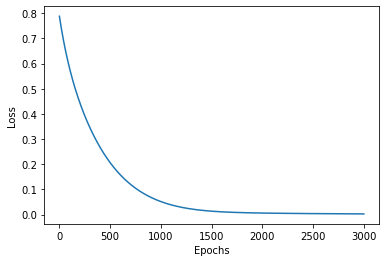

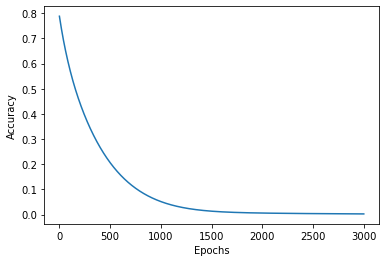

In [16]:
for i, key in enumerate(history.history.keys()):
  show_history(history, key, history_plot_keys[i])